Using cache found in C:\Users\mazsolamacko/.cache\torch\hub\moskomule_senet.pytorch_master


test dataset size:  32768
Accuracy: 85.43%


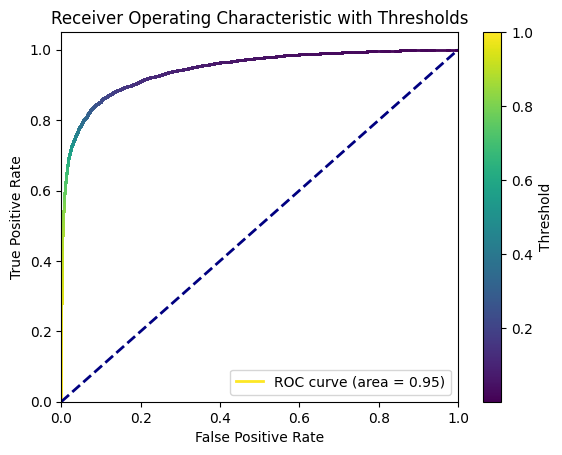

In [1]:
##########################################################################################################
# Author: Mihaly Sulyok & Peter Karacsonyi                                                               #
# Last updated: 2024 jan 4                                                                               #
# This workbook evaluates a trained model on a test dataset                                              #
# Input: model type, saved weights, session name and test data                                           #
# Output: accuracy, roc/auc graph, top false negative images                                             #
##########################################################################################################

import lib
from torchvision.datasets import PCAM
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter 
# tensorboard --logdir /mnt/bigdata/placenta/tensorboard_data
# firefox http://localhost:6006/
from torch import float32
from torch.hub import load
from torch.nn import Linear

# convert to tensor
transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(float32, scale=True),
    ]
)

#########
# usage #
#########

##########################################################################
# set session name, model type, test data and session name from training #
##########################################################################

# append to tensorboard report (get session name first)
# training session name for tensorboard
session_name = "senet-50-augmented"
# (down)load
pcam_test_dataset = PCAM(
    root="G:\\pcam\\", transform=transforms, split="test", download=True
)
# model type
model = load(
    'moskomule/senet.pytorch',
    'se_resnet50',
    verbose=True
)
# saved weights / checkpoint file
checkpoint_file = "G:\\pcam\\senet-50\\augment.ckpt"
# custom model configuration
num_ftrs = model.fc.in_features
model.fc = Linear(num_ftrs, 2)



# initiate tensorboard writer
writer = SummaryWriter(log_dir=f"G:\\pcam\\tensorboard_data\\{session_name}\\", comment="test-results")
# load data
test_loader = DataLoader(pcam_test_dataset, batch_size=16, shuffle=True, num_workers=0)

# draw the model structure (tensorboard)
# writer.add_graph(model)

print("test dataset size: ", len(pcam_test_dataset))

# run
worst_fns = lib.test_model(
    test_loader, checkpoint_file, "cuda", model, session_name
)

# retrieve the top 20 worst false negative images
fn_top20_images = []
fn_top20_preds = []
for pred, image_id in worst_fns[:20]:
    image, _ = pcam_test_dataset[image_id] 
    fn_top20_images.append(image)
    fn_top20_preds.append(str(pred))

def show(inp, label):
    fig = plt.gcf()
    plt.imshow(inp.permute(1,2,0))
    plt.title(label)
    plt.show()
    return fig

grid = make_grid(fn_top20_images)
grid_labels = [str(fn_top20_preds[x]) for x in range(len(fn_top20_images))]
fig = show(grid, label=grid_labels)

# write to tensorboard as well
writer.add_figure("top_20_false_negatives", fig, global_step=None, close=True, walltime=None)
writer.close()